In [1]:
import torch
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import functional as F_t
import torchvision.ops as ops

from util.box_ops import box_xyxy_to_cxcywh, box_cxcywh_to_xyxy

from scipy.spatial.distance import mahalanobis

from models import build_model
from models.matcher import build_matcher

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns

from collections import Counter

import util.misc as utils

from util.misc import NestedTensor
from torch.utils.data import DataLoader

from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms
from util import box_ops

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from tqdm import tqdm
import os

from args import Args

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

# 모델과 postprocessor 준비
model, _, postprocessors, exemplar_selection, contextual_labeling = build_model(args, mode=args.model_type)
model.to(device)

# 체크포인트 로드 (옵션) / Load checkpoint (optional)
checkpoint = torch.load("./test_model/my1/t1.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized Contextual Labeling Module


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [3]:
def get_datasets(args):
    print(args.dataset)

    train_set = args.train_set
    test_set = args.test_set
    dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set), dataset = args.dataset)
    dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset = args.dataset, transforms=make_coco_transforms(args.test_set))

    print(args.train_set)
    print(args.test_set)
    print(dataset_train)
    print(dataset_val)

    return dataset_train, dataset_val

def preprocess_image(image_path, device):
    """
    쿼리 이미지 전처리 함수: 모델이 요구하는 입력 형식으로 변환
    """
    image = Image.open(image_path).convert('RGB')
    w, h = image.size

    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)  # (1, C, H, W)
    return NestedTensor(img_tensor, torch.zeros_like(img_tensor[:, 0]))  # NestedTensor 변환

# Feature Representation 추출
def extract_encoder_features(model, features, pos, masks, samples):
    """
    Backbone을 통과한 Feature Map을 Transformer Encoder 입력 형식으로 변환
    """
    srcs, masks = [], []
    for l, feat in enumerate(features):
        src, mask = feat.decompose()
        srcs.append(model.input_proj[l](src))
        masks.append(mask)

    if model.num_feature_levels > len(srcs):
        _len_srcs = len(srcs)
        for l in range(_len_srcs, model.num_feature_levels):
            if l == _len_srcs:
                src = model.input_proj[l](features[-1].tensors)
            else:
                src = model.input_proj[l](srcs[-1])
            m = samples.mask
            mask = F.interpolate(m[None].float(), size=src.shape[-2:]).to(torch.bool)[0]
            pos_l = model.backbone[1](NestedTensor(src, mask)).to(src.dtype)
            srcs.append(src)
            masks.append(mask)
            pos.append(pos_l)

    # Feature Map 크기 변환
    src_flatten, mask_flatten, lvl_pos_embed_flatten, spatial_shapes = [], [], [], []
    for lvl, (src, mask) in enumerate(zip(srcs, masks)):
        bs, c, h, w = src.shape
        spatial_shapes.append((h, w))
        src = src.flatten(2).transpose(1, 2)
        mask = mask.flatten(1)
        lvl_pos_embed = model.transformer.level_embed[lvl].unsqueeze(0).repeat(1, src.shape[1], 1)
        lvl_pos_embed_flatten.append(lvl_pos_embed)
        src_flatten.append(src)
        mask_flatten.append(mask)

    src_flatten = torch.cat(src_flatten, 1)
    mask_flatten = torch.cat(mask_flatten, 1)
    lvl_pos_embed_flatten = torch.cat(lvl_pos_embed_flatten, 1)
    spatial_shapes = torch.as_tensor(spatial_shapes, dtype=torch.long, device=src_flatten.device)
    level_start_index = torch.cat((spatial_shapes.new_zeros((1, )), (spatial_shapes[:,0]*spatial_shapes[:,1]).cumsum(0)[:-1]))
    valid_ratios = torch.stack([model.transformer.get_valid_ratio(m) for m in masks], 1)

    # encoder
    memory = model.transformer.encoder(src_flatten, spatial_shapes, level_start_index, valid_ratios, lvl_pos_embed_flatten, mask_flatten)

    return memory, spatial_shapes, level_start_index, valid_ratios, mask_flatten

# Query Embedding 추출
def extract_decoder_embedding(model, memory, spatial_shapes, level_start_index, valid_ratios, mask_flatten):
    """
    Backbone을 통과한 Feature Map을 Transformer Encoder 입력 형식으로 변환
    """
    print(model.query_embed.weight)
    query_embed = model.query_embed.weight
    # prepare input for decoder
    bs, _, c = memory.shape
    if model.two_stage:
        output_memory, output_proposals = model.gen_encoder_output_proposals(memory, mask_flatten, spatial_shapes)

        # hack implementation for two-stage Deformable DETR
        enc_outputs_class = model.decoder.class_embed[model.decoder.num_layers](output_memory)
        enc_outputs_coord_unact = model.decoder.bbox_embed[model.decoder.num_layers](output_memory) + output_proposals

        topk = model.two_stage_num_proposals
        topk_proposals = torch.topk(enc_outputs_class[..., 0], topk, dim=1)[1] ##TODO?? Why only based on first dimension??
        topk_coords_unact = torch.gather(enc_outputs_coord_unact, 1, topk_proposals.unsqueeze(-1).repeat(1, 1, 4))
        topk_coords_unact = topk_coords_unact.detach()
        reference_points = topk_coords_unact.sigmoid()
        init_reference_out = reference_points
        pos_trans_out = model.pos_trans_norm(model.pos_trans(model.get_proposal_pos_embed(topk_coords_unact)))
        query_embed, tgt = torch.split(pos_trans_out, c, dim=2)
    else:
        query_embed, tgt = torch.split(query_embed, c, dim=1)
        query_embed = query_embed.unsqueeze(0).expand(bs, -1, -1)
        tgt = tgt.unsqueeze(0).expand(bs, -1, -1)
        reference_points = model.transformer.reference_points(query_embed).sigmoid()
        init_reference_out = reference_points

    # decoder
    hs, inter_references = model.transformer.decoder(tgt, reference_points, memory, spatial_shapes, level_start_index, valid_ratios, query_embed, mask_flatten)

    inter_references_out = inter_references

    if model.two_stage:
        return hs, init_reference_out, inter_references_out, enc_outputs_class, enc_outputs_coord_unact

    #return hs, init_reference_out, inter_references_out, None, None
    return hs[-1].cpu().detach().numpy()

def apply_nms(boxes, scores, labels, iou_threshold=0.5):
    """
    NMS 적용 함수
    
    Args:
        boxes: 바운딩 박스 좌표 [N, 4]
        scores: 각 박스의 confidence score [N]
        labels: 각 박스의 클래스 레이블 [N]
        iou_threshold: NMS에서 사용할 IoU threshold
    """
    # 클래스별로 NMS 적용
    unique_labels = torch.unique(labels)
    keep_boxes = []
    keep_scores = []
    keep_labels = []
    
    for label in unique_labels:
        # 현재 클래스의 박스들만 선택
        class_mask = labels == label
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]
        
        # NMS 적용
        keep_idx = ops.nms(class_boxes, class_scores, iou_threshold)
        
        # 결과 저장
        keep_boxes.append(boxes[class_mask][keep_idx])
        keep_scores.append(scores[class_mask][keep_idx])
        keep_labels.append(labels[class_mask][keep_idx])
    
    # 모든 클래스의 결과 합치기
    if keep_boxes:
        keep_boxes = torch.cat(keep_boxes)
        keep_scores = torch.cat(keep_scores)
        keep_labels = torch.cat(keep_labels)
        return keep_boxes, keep_scores, keep_labels
    else:
        return boxes, scores, labels

def visualize_detection(image, outputs, class_names, known_score_threshold=0.3, unknown_score_threshold=0.6, unknown_label_id=80, iou_threshold=0.5):
    """
    Detection 결과 시각화 함수 (NMS 포함)
    """
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    
    # 이미지 표시
    ax.imshow(image)
    
    # 색상 맵 설정
    colors = plt.cm.rainbow(np.linspace(0, 1, unknown_label_id))
    
    # 첫 번째 이미지의 결과 가져오기
    result = outputs[0]
    
    # 각 detection에 대해
    scores = result['scores'].cpu()
    labels = result['labels'].cpu()
    boxes = result['boxes'].cpu()
    
    # score threshold 적용
    known_keep = (labels < unknown_label_id) & (scores > known_score_threshold)
    unknown_keep = (labels == unknown_label_id) & (scores > unknown_score_threshold)
    keep = known_keep | unknown_keep
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]
    
    # NMS 적용
    boxes, scores, labels = apply_nms(boxes, scores, labels, iou_threshold)
    
    for score, label, box in zip(scores, labels, boxes):
        cls_id = label.item()
        
        # 박스 좌표
        xmin = float(box[0])
        ymin = float(box[1])
        xmax = float(box[2])
        ymax = float(box[3])
        
        # 박스 그리기
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin, 
            linewidth=2, 
            edgecolor=colors[cls_id] if cls_id < unknown_label_id else 'red',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 클래스 레이블과 confidence score 표시
        class_name = class_names[cls_id]
        ax.text(
            xmin, ymin - 5,
            f'{class_name} {score:.2f}',
            color=colors[cls_id] if cls_id < unknown_label_id else 'red',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            fontsize=8
        )
    
    plt.axis('off')
    plt.show()


def run_inference(model, postprocessors, image_path, device='cuda'):
    """
    이미지에 대한 전체 추론 과정을 수행
    """
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    w, h = image.size
    
    # 이미지 전처리
    transform = T.Compose([
        T.Resize([800]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    print(f"Image shape: {img_tensor.shape}")

    # 원본 이미지 크기
    target_sizes = torch.tensor([[h, w]], device=device)
    
    # 모델 추론
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        results = postprocessors['bbox'](outputs, target_sizes)
    
    return image, results

In [4]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown']

In [5]:
dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD
owod_t1_train
owod_all_task_test
Dataset OWDetection
    Number of datapoints: 16551
    Root location: ./data/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 10246
    Root location: ./data/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [6]:
matcher = build_matcher(args)

In [7]:
def extract_matched_embeddings(model, matcher, data_loader, device, save_path="matched_embeddings.npz"):
    """
    모든 테스트 이미지에서 GT에 매칭된 query embedding, label, box, score를 추출하고 저장하는 함수
    """
    if os.path.exists(save_path):
        print(f"✅ 이미 존재하는 matched embeddings 파일: {save_path}")
        return

    model.eval()
    all_embeddings = []
    all_labels = []
    all_boxes = []
    all_logits = []
    all_obj = []
    all_scores = []

    with torch.no_grad():
        for samples, targets in tqdm(data_loader, desc="Extracting matched queries"):
            samples = samples.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(samples)
            embeddings = outputs["query_embeddings"]  # [B, Q, D]
            pred_boxes = outputs["pred_boxes"]
            pred_logits = outputs["pred_logits"]
            pred_obj = outputs["pred_obj"]  # objectness

            matched_indices = matcher(outputs, targets)

            for b_idx, (src_idx, tgt_idx) in enumerate(matched_indices):
                if len(src_idx) == 0:
                    continue

                # embedding, box, logit 저장
                matched_q = embeddings[b_idx][src_idx]
                matched_boxes = pred_boxes[b_idx][src_idx]
                matched_logits = pred_logits[b_idx][src_idx]
                matched_obj = pred_obj[b_idx][src_idx]

                all_embeddings.append(matched_q.cpu())
                all_boxes.append(matched_boxes.cpu())
                all_logits.append(matched_logits.cpu())
                all_obj.append(matched_obj.cpu())

                obj_prob = torch.exp(-(args.obj_temp/args.hidden_dim) * matched_obj).unsqueeze(-1)  # [M]
                final_score = (obj_prob * matched_logits.sigmoid()).cpu()  # [M]
                all_scores.append(final_score)

                labels_this_batch = targets[b_idx]["labels"][tgt_idx].cpu().tolist()
                all_labels.extend(labels_this_batch)

    # numpy로 변환 및 저장
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    all_labels = np.array(all_labels)
    all_boxes = torch.cat(all_boxes, dim=0).numpy()
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    all_obj = torch.cat(all_obj, dim=0).numpy()

    np.savez(save_path, embeddings=all_embeddings, labels=all_labels,
             boxes=all_boxes, logits=all_logits, scores=all_scores, obj=all_obj)
    print(f"✅ Matched embeddings 저장 완료: {save_path} | 개수: {len(all_embeddings)}")

    return all_embeddings, all_labels, all_boxes, all_scores, all_obj

def extract_unmatched_embeddings_from_image(model, matcher, image_tensor, target, device, save_path="unmatched_embedding.npz"):
    model.eval()
    
    image_tensor = image_tensor.to(device)
    target = [{k: v.to(device) for k, v in target.items()}]

    with torch.no_grad():
        outputs = model(image_tensor)
        query_embeddings = outputs["query_embeddings"][0]  # [Q, D]
        pred_boxes = outputs["pred_boxes"][0]              # [Q, 4]
        pred_logits = outputs["pred_logits"][0]            # [Q, C+1]

        matched_indices = matcher(outputs, target)[0]
        matched_query_indices = matched_indices[0].cpu().tolist()

        all_indices = set(range(pred_logits.shape[0]))
        unmatched_indices = list(all_indices - set(matched_query_indices))

        unmatched_embeddings = query_embeddings[unmatched_indices].cpu().numpy()
        unmatched_boxes = pred_boxes[unmatched_indices].cpu().numpy()
        unmatched_scores = pred_logits[unmatched_indices].softmax(-1).max(-1).values.cpu().numpy()

        # 저장
        np.savez(save_path,
                 embeddings=unmatched_embeddings,
                 boxes=unmatched_boxes,
                 scores=unmatched_scores)
        print(f"✅ Unmatched query 저장 완료: {save_path}")

        return unmatched_embeddings, unmatched_boxes, unmatched_scores

def visualize_matched_vs_unmatched(matched_path, unmatched_path, method="PCA"):
    matched = np.load(matched_path)
    unmatched = np.load(unmatched_path)

    matched_embeddings = matched["embeddings"]
    matched_labels = matched["labels"]
    unmatched_embeddings = unmatched["embeddings"]

    all_embeddings = np.concatenate([matched_embeddings, unmatched_embeddings], axis=0)
    matched_len = len(matched_embeddings)

    # 차원 축소
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "T-SNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("method must be 'PCA', 'T-SNE', or 'UMAP'")

    reduced = reducer.fit_transform(all_embeddings)

    # 시각화
    plt.figure(figsize=(10, 7))
    unique_labels = np.unique(matched_labels)
    cmap = plt.get_cmap("tab20", lut=len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    # ✅ matched part만 slicing해서 마스크 적용
    reduced_matched = reduced[:matched_len]

    for i, label in enumerate(unique_labels):
        mask = (matched_labels == label)
        plt.scatter(reduced_matched[mask, 0], reduced_matched[mask, 1],
                    s=10, alpha=0.6,
                    label=f"{str(label)} {class_names[label]}", color=label_to_color[label])

    # ✅ unmatched part 시각화
    reduced_unmatched = reduced[matched_len:]
    plt.scatter(reduced_unmatched[:, 0], reduced_unmatched[:, 1],
                s=80, c='red', marker='X', label='unmatched')

    plt.title(f"{method} visualization: matched vs unmatched")
    plt.xlabel(f"{method}-1")
    plt.ylabel(f"{method}-2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_sample_from_dataloader(data_loader, index):
    """
    DataLoader 내부의 Dataset에서 특정 인덱스의 데이터를 가져오는 함수

    Args:
        data_loader: PyTorch DataLoader 객체
        index (int): 추출할 데이터 인덱스

    Returns:
        image_tensor: shape (1, 3, H, W)
        target: dict
    """
    dataset = data_loader.dataset
    image, target = dataset[index]

    if isinstance(image, np.ndarray):
        from torchvision.transforms.functional import to_tensor
        image = to_tensor(image)

    if image.ndim == 3:
        image = image.unsqueeze(0)  # [3, H, W] → [1, 3, H, W]

    return image, target

In [8]:
save_path="matched_embeddings.npz"

if os.path.exists(save_path):
    print(f"✅ 이미 존재하는 matched embeddings 파일: {save_path}")
    data = np.load(save_path)
else:
    all_embeddings, all_labels, all_boxes, all_scores, all_obj = extract_matched_embeddings(model, matcher, data_loader_val, device, save_path="matched_embeddings.npz")

✅ 이미 존재하는 matched embeddings 파일: matched_embeddings.npz


In [9]:
all_embeddings = data["embeddings"]
all_labels = data["labels"]
all_boxes = data["boxes"]
all_scores = data["scores"]
all_obj = data["obj"]
all_logits = data["logits"]

In [10]:
all_embeddings.shape, all_labels.shape, all_boxes.shape, all_scores.shape, all_obj.shape

((42131, 256), (42131,), (42131, 4), (42131, 81), (42131,))

In [11]:
all_logits

array([[-5.672312 , -5.0969377, -3.6104007, ..., -4.125131 , -5.787978 ,
         1.1426268],
       [-6.6629066, -4.720675 , -4.5502577, ..., -3.8211293, -6.0063076,
        -2.326793 ],
       [-3.3172307, -7.1491857, -4.968841 , ..., -3.933464 , -5.871168 ,
        -1.9133723],
       ...,
       [-6.70662  , -4.5625744, -4.4647155, ..., -3.8126483, -5.986242 ,
        -2.3666182],
       [-5.959226 , -5.3717213, -3.8911805, ..., -4.168048 , -5.7937946,
         1.568255 ],
       [-6.70662  , -4.5625744, -4.4647155, ..., -3.8126483, -5.986242 ,
        -2.3666182]], dtype=float32)

In [ ]:
dataset = data_loader_val.dataset
image, target = dataset[0]
image = image.unsqueeze(0)
target_size = torch.stack([target['orig_size']], dim=0).to(device)

TypeError: expected Tensor as element 0 in argument 0, but got dict

In [13]:
outputs = model(image.to(device))

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
outputs['pred_obj'].shape

torch.Size([1, 100])

In [25]:
result = postprocessors['bbox'](outputs, target_size)

/home/dan/Desktop/Contextual_Labeling/models/prob_deformable_detr.py:539: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes // out_logits.shape[2] # 각 인덱스가 속한 바운딩 박스 인덱스


In [18]:
result[0]['scores']

tensor([0.8026, 0.7862, 0.7848, 0.7834, 0.7706, 0.7648, 0.7639, 0.7560, 0.7559,
        0.7347, 0.7330, 0.7288, 0.7285, 0.7256, 0.7169, 0.7167, 0.7146, 0.7091,
        0.7048, 0.7023, 0.6969, 0.6966, 0.6843, 0.6760, 0.6720, 0.6625, 0.6293,
        0.6249, 0.5913, 0.4753, 0.4571, 0.4100, 0.3333, 0.3319, 0.2759, 0.2468,
        0.2307, 0.2123, 0.2108, 0.2106, 0.2091, 0.2070, 0.1939, 0.1929, 0.1928,
        0.1915, 0.1877, 0.1824, 0.1792, 0.1790, 0.1732, 0.1723, 0.1702, 0.1685,
        0.1677, 0.1671, 0.1656, 0.1655, 0.1653, 0.1643, 0.1637, 0.1634, 0.1629,
        0.1627, 0.1590, 0.1546, 0.1529, 0.1527, 0.1504, 0.1496, 0.1496, 0.1493,
        0.1492, 0.1492, 0.1491, 0.1489, 0.1486, 0.1479, 0.1479, 0.1477, 0.1473,
        0.1463, 0.1461, 0.1458, 0.1457, 0.1446, 0.1444, 0.1443, 0.1441, 0.1433,
        0.1402, 0.1376, 0.1374, 0.1363, 0.1357, 0.1348, 0.1342, 0.1320, 0.1310,
        0.1306], device='cuda:0')

In [ ]:
matched_indices = matcher(outputs, target)

IndexError: too many indices for tensor of dimension 1

# 1 단계

In [ ]:
if not os.path.exists("test_outputs_with_embeddings.npz"):
    all_embeddings = []
    all_boxes = []
    all_labels = []
    all_scores = []
    all_image_ids = []

    C = 80  # 클래스 개수

    for batch in tqdm(data_loader_val):
        images, targets = batch
        images = images.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        # 출력 정보
        logits = outputs["pred_logits"].softmax(-1)         # (1, Q, C+1)
        pred_labels = logits.argmax(-1)                     # (1, Q)
        scores = logits.max(-1).values                      # (1, Q)
        boxes = outputs["pred_boxes"]                       # (1, Q, 4)
        query_embeddings = outputs["query_embeddings"]      # (1, Q, D)
        image_id = targets[0]["image_id"].item()

        for i in range(logits.shape[1]):
            label = pred_labels[0, i].item()
            box = boxes[0, i].cpu().numpy().tolist()
            score = scores[0, i].item()
            embedding = query_embeddings[0, i].cpu().numpy()

            label_name = "unknown" if label == C else label  # 또는 클래스 이름 매핑

            all_embeddings.append(embedding)
            all_boxes.append(box)
            all_labels.append(label_name)
            all_scores.append(score)
            all_image_ids.append(image_id)

    np.savez("test_outputs_with_embeddings.npz",
            embeddings=np.array(all_embeddings),
            boxes=np.array(all_boxes),
            labels=np.array(all_labels),
            scores=np.array(all_scores),
            image_ids=np.array(all_image_ids))

/tmp/ipykernel_24009/3893848776.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


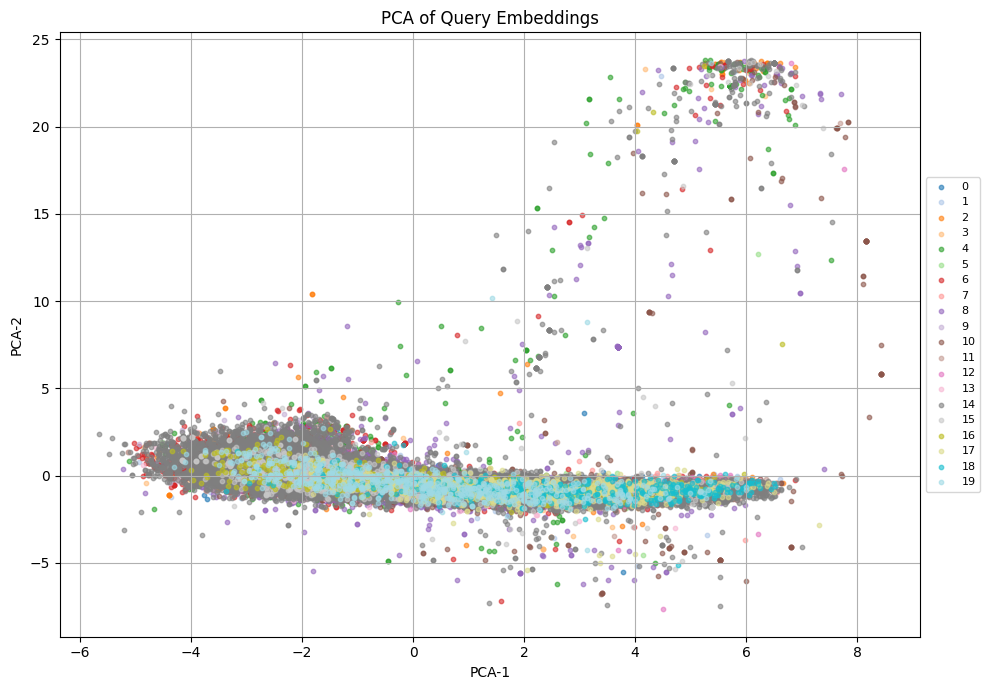

In [ ]:
# 1단계 결과 불러오기
data = np.load("matched_embeddings.npz")
embeddings = data["embeddings"]   # [N, D]
labels = data["labels"]           # [N]
# scores = data["scores"]

# Optional: Unknown 제외하거나 선택
# mask = (labels != "unknown")
# embeddings = embeddings[mask]
# labels = labels[mask]

# PCA 적용
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)  # [N, 2]

# 시각화
plt.figure(figsize=(10, 7))
unique_labels = np.unique(labels)

colors = plt.cm.get_cmap('tab20', len(unique_labels))

for idx, label in enumerate(unique_labels):
    mask = (labels == label)
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], s=10, alpha=0.6, label=str(label), color=colors(idx))

plt.title("PCA of Query Embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
data['embeddings'].shape

(42131, 256)

In [ ]:
data['labels'].shape

(42131,)

/tmp/ipykernel_24009/636698420.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


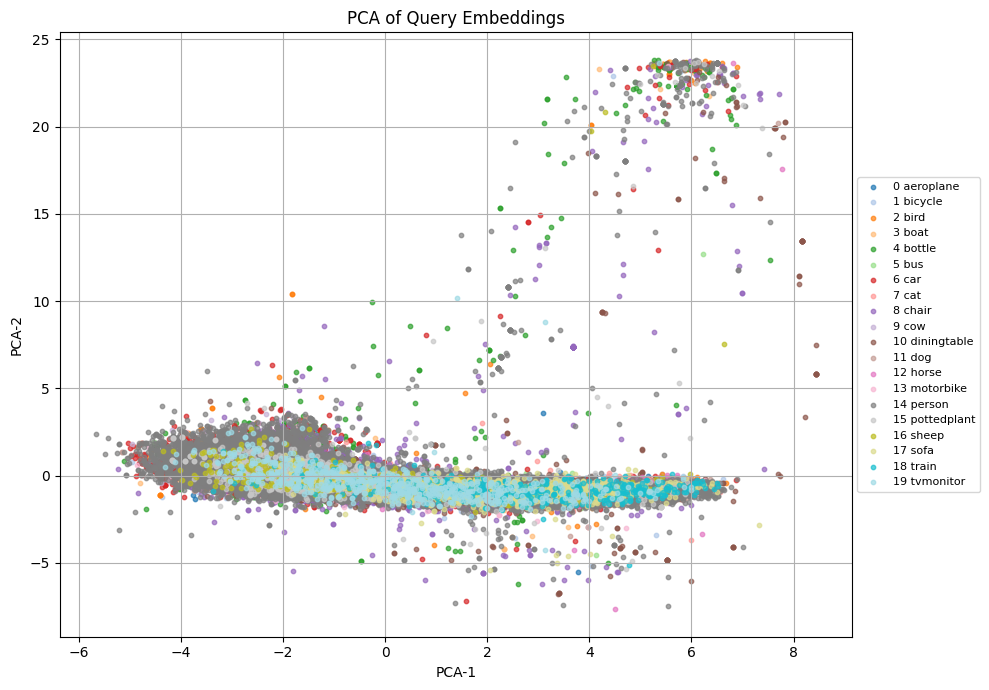

/tmp/ipykernel_24009/636698420.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


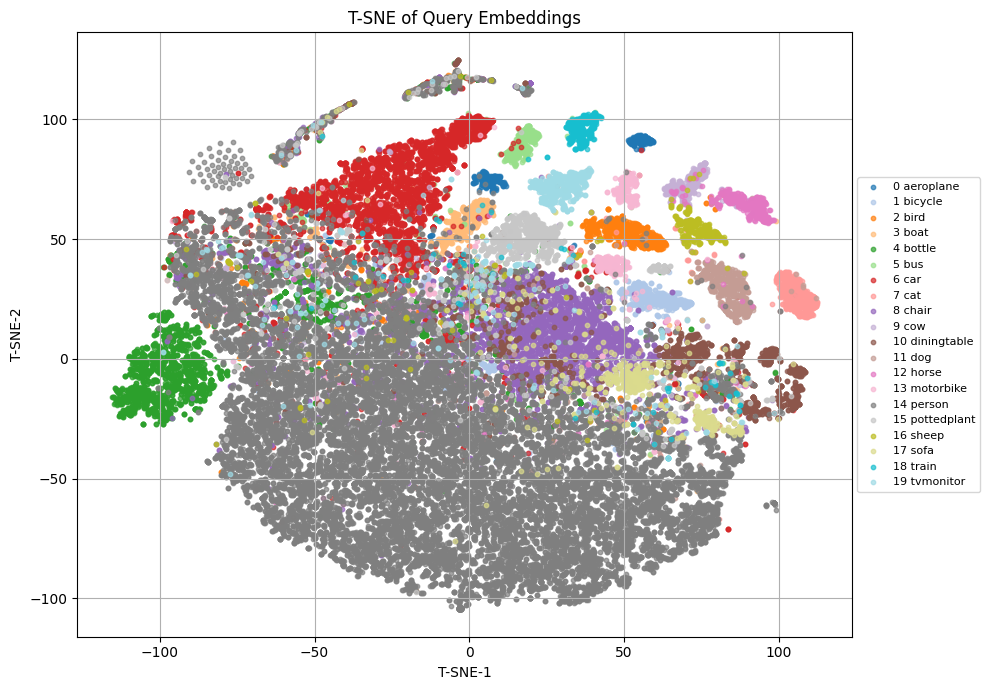

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_24009/636698420.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


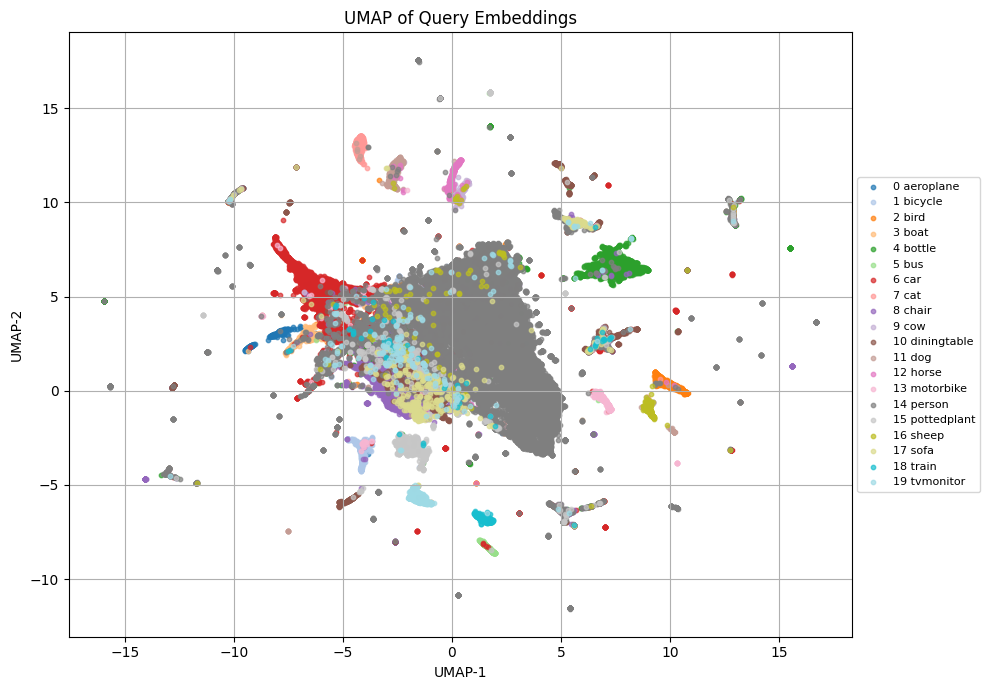

In [ ]:
# 📦 저장된 .npz 파일 불러오기
data = np.load("matched_embeddings.npz")
embeddings = data["embeddings"]   # [N, D]
labels = data["labels"]           # [N]

# # Optional: Unknown 제외하거나 선택
# mask = (labels != "unknown")
# embeddings = embeddings[mask]
# labels = labels[mask]

# 라벨 인덱스 정리 (for coloring)
unique_labels = np.unique(labels)
label_to_index = {k: i for i, k in enumerate(unique_labels)}
label_indices = np.array([label_to_index[label] for label in labels])

# 🎨 시각화 함수 정의
def visualize_2d(embedding_2d, method_name):
    plt.figure(figsize=(10, 7))
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    for idx, label in enumerate(unique_labels):
        mask = (labels == label)
        plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1],
                    s=10, alpha=0.7, label=f"{str(label)} {class_names[label]}", color=cmap(idx))

    plt.title(f"{method_name} of Query Embeddings")
    plt.xlabel(f"{method_name}-1")
    plt.ylabel(f"{method_name}-2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ PCA
pca_result = PCA(n_components=2).fit_transform(embeddings)
visualize_2d(pca_result, "PCA")

# ✅ T-SNE
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)
visualize_2d(tsne_result, "T-SNE")

# ✅ UMAP
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
visualize_2d(umap_result, "UMAP")

In [ ]:
def visualize_embeddings_2d(embedding_2d, labels, method_name="PCA", top_k=None, include_only=None):
    """
    쿼리 임베딩 시각화 함수
    
    Args:
        embedding_2d (np.array): [N, 2], 차원 축소된 임베딩
        labels (np.array): [N], 각 포인트에 해당하는 클래스 (str 또는 int)
        method_name (str): 시각화 타이틀용 방법 이름 (PCA, T-SNE, UMAP 등)
        top_k (int): 가장 자주 등장한 상위 K개 클래스만 시각화
        include_only (list): 시각화할 클래스 이름 리스트 (원하는 클래스만 지정 가능)
    """
    # ✅ 라벨 정리
    labels = np.array(labels)
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_freq = dict(zip(unique_labels, counts))

    # Optional: Unknown 제외하거나 선택
    mask = (labels != "unknown")
    embedding_2d = embedding_2d[mask]
    labels = labels[mask]

    # ✅ top_k 필터링
    if top_k is not None:
        top_k_labels = [label for label, _ in Counter(labels).most_common(top_k)]
        mask = np.isin(labels, top_k_labels)
        embedding_2d = embedding_2d[mask]
        labels = labels[mask]

    # ✅ include_only 필터링
    if include_only is not None:
        mask = np.isin(labels, include_only)
        embedding_2d = embedding_2d[mask]
        labels = labels[mask]

    # ✅ 라벨 → 색상 매핑
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('rainbow', len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    # ✅ 시각화
    plt.figure(figsize=(10, 7))
    for label in unique_labels:
        mask = (labels == label)
        plt.scatter(
            embedding_2d[mask, 0],
            embedding_2d[mask, 1],
            s=10,
            alpha=0.7,
            label=f"[{label}] {class_names[int(label)]}",
            color=label_to_color[label]
        )

    plt.title(f"{method_name} of Query Embeddings")
    plt.xlabel(f"{method_name}-1")
    plt.ylabel(f"{method_name}-2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

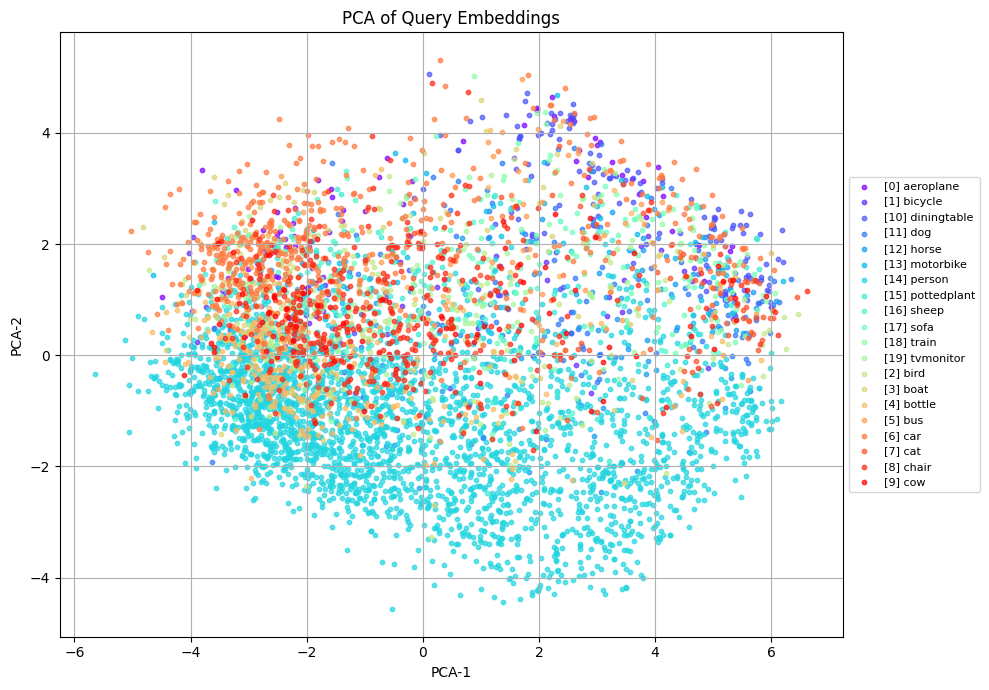

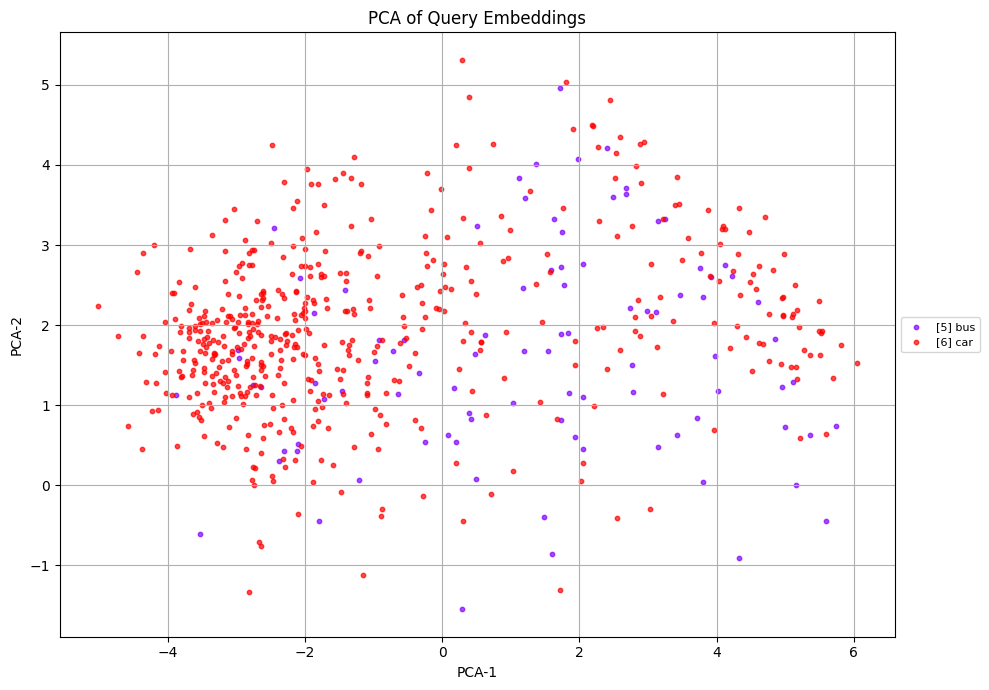

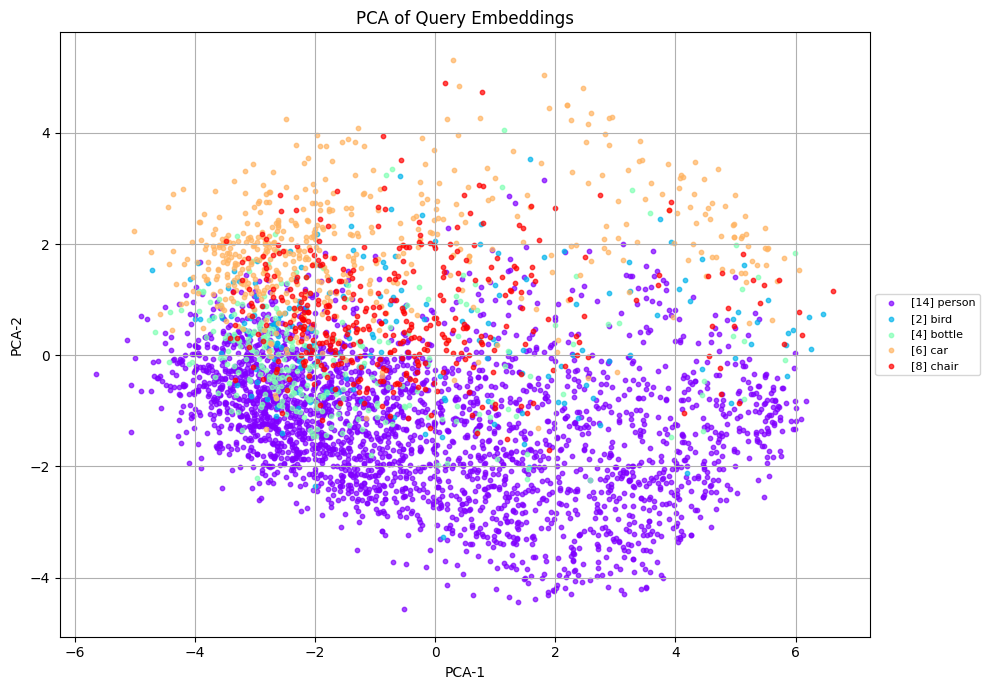

In [ ]:
# 전체 시각화
visualize_embeddings_2d(pca_result, labels, method_name="PCA")

# "car", "bus", "unknown" 만 시각화
visualize_embeddings_2d(pca_result, labels, method_name="PCA", include_only=['6', '5', '80'])

# 등장 빈도 기준 top-5 클래스만 시각화
visualize_embeddings_2d(pca_result, labels, method_name="PCA", top_k=5)

In [ ]:
def extract_unknown_query_from_image(model, image_tensor, known_embeddings, known_labels, C, threshold=0.5):
    """
    특정 이미지에서 Unknown으로 추정되는 query의 임베딩을 추출하여
    기존 임베딩/라벨 리스트에 추가하는 함수
    
    Args:
        model: 학습된 OWOD 모델
        image_tensor: shape (1, 3, H, W), 단일 이미지
        known_embeddings: np.array of shape [N, D]
        known_labels: list of labels, len N
        C: Known 클래스 수 (C+1 번째가 Unknown)
        threshold: 선택 기준으로 사용될 softmax score 또는 objectness score 하한

    Returns:
        updated_embeddings, updated_labels
    """
    model.eval()
    image_tensor = image_tensor.to(next(model.parameters()).device)

    with torch.no_grad():
        outputs = model(image_tensor)

    # Query 임베딩
    query_embeddings = outputs["query_embeddings"][0]  # [Q, D]
    pred_logits = outputs["pred_logits"][0].softmax(-1)  # [Q, C+1]
    pred_labels = pred_logits.argmax(-1)  # [Q]
    pred_scores = pred_logits.max(-1).values  # [Q]

    # Unknown 후보 필터링
    unknown_indices = (pred_labels == C) & (pred_scores > threshold)

    if unknown_indices.sum() == 0:
        print("⚠️ Unknown query not found above threshold.")
        return known_embeddings, known_labels

    # 가장 점수가 높은 Unknown query 하나 선택
    top_idx = torch.argmax(pred_scores * unknown_indices.float()).item()
    unknown_embedding = query_embeddings[top_idx].cpu().numpy()

    # 기존 임베딩에 추가
    updated_embeddings = np.vstack([known_embeddings, unknown_embedding])
    updated_labels = list(known_labels) + ["unknown"]

    print(f"✅ Unknown query #{top_idx} 추가됨. 점수: {pred_scores[top_idx].item():.3f}")
    return updated_embeddings, updated_labels

In [ ]:
data_index = 21
with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(tqdm(data_loader_val)):
        
        if batch_idx != data_index:
            continue
        image = images.to(device)
        if batch_idx == data_index:
            break

updated_embeddings, updated_labels = extract_unknown_query_from_image(
    model, image, data['embeddings'].copy(), data['labels'].copy(), C=80, threshold=0.5
)

  1%|          | 21/2050 [00:01<01:39, 20.40it/s]
/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Unknown query #52 추가됨. 점수: 0.996


In [ ]:
def visualize_with_unknown(embeddings, labels, method="PCA"):
    # Optional: Unknown 제외하거나 선택
    mask = (labels != "unknown")
    embeddings = embeddings[mask]
    labels = labels[mask]

    # 차원 축소
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "T-SNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("method must be 'PCA', 'T-SNE', or 'UMAP'")

    embedding_2d = reducer.fit_transform(embeddings)

    # 라벨 정리
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab20', lut=len(unique_labels))
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    label_to_color = {label: cmap(i) for label, i in label_to_index.items()}

    # 시각화
    plt.figure(figsize=(10, 7))
    for label in unique_labels:
        mask = (labels == label)
        if label == "unknown":
            plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1],
                        s=80, c='red', marker='X', label="unknown (added)", edgecolor='black')
        else:
            plt.scatter(embedding_2d[mask, 0], embedding_2d[mask, 1],
                        s=10, alpha=0.6, label=f"[{label_to_index[label]}] {label}",
                        color=label_to_color[label])

    plt.title(f"{method} after Unknown Injection")
    plt.xlabel(f"{method}-1")
    plt.ylabel(f"{method}-2")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_with_unknown(updated_embeddings, updated_labels, method="PCA")
visualize_with_unknown(updated_embeddings, updated_labels, method="T-SNE")
visualize_with_unknown(updated_embeddings, updated_labels, method="UMAP")

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


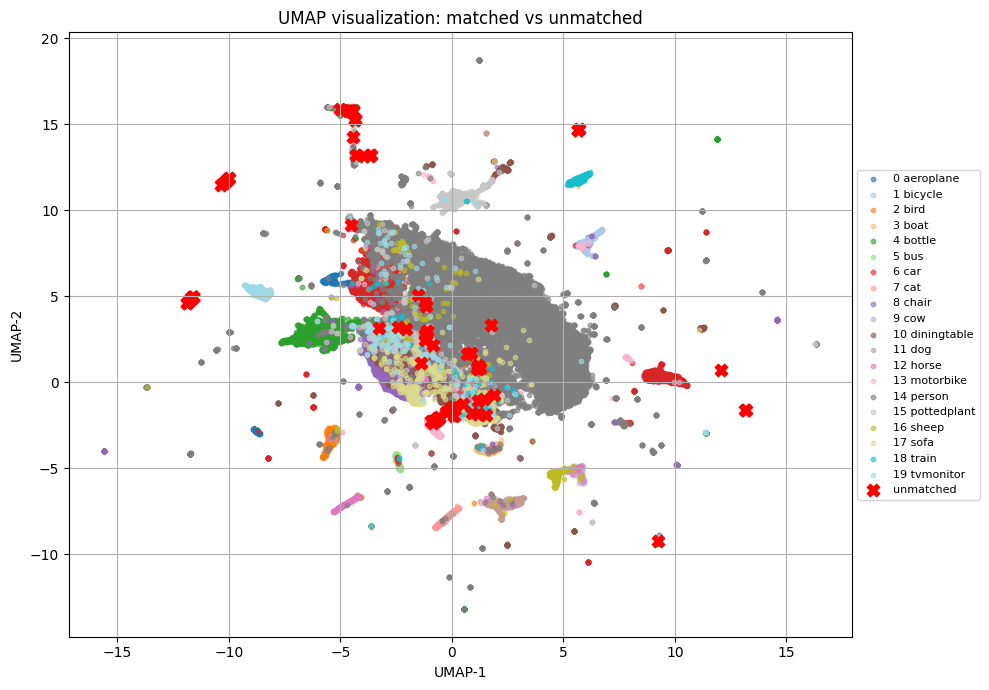

In [ ]:
visualize_matched_vs_unmatched(
    matched_path="matched_embeddings.npz",
    unmatched_path="unmatched_embedding.npz",
    method="UMAP"  # or "T-SNE", "UMAP"
 )

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def visualize_unmatched_boxes_on_pil_image(pil_image, boxes, scores=None, title="Unmatched Queries", dpi=100):
    """
    pil_image: PIL.Image (원본)
    boxes: [N, 4] (cx, cy, w, h) normalized format
    scores: [N] or None
    """
    img_w, img_h = pil_image.size
    fig_w, fig_h = img_w / dpi, img_h / dpi
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.imshow(pil_image)

    for i, box in enumerate(boxes):
        cx, cy, w, h = box
        x = (cx - w / 2) * img_w
        y = (cy - h / 2) * img_h
        w = w * img_w
        h = h * img_h

        rect = patches.Rectangle((x, y), w, h, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label = f"{i}" if scores is None else f"{i} ({scores[i]:.2f})"
        ax.text(x, y - 5, label, color='red', fontsize=10,
                bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# COCO 또는 일반적인 이미지넷 정규화 기준 (필요시 수정)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def tensor_to_pil_image(tensor):
    """
    [C, H, W] 텐서를 원본 PIL 이미지로 복원 (정규화 해제)
    """
    # 정규화 해제
    unnormalize = T.Normalize(
        mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
        std=[1/s for s in IMAGENET_STD]
    )
    tensor = unnormalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    pil_image = F_t.to_pil_image(tensor)
    return pil_image


def visualize_unmatched_queries(model, matcher, image_tensor, target, device, score_threshold=0.5):
    """
    모델의 output에서 unmatched query를 찾아 원본 이미지 위에 박스 시각화
    """
    model.eval()
    image_tensor = image_tensor.to(device).unsqueeze(0)  # [1, C, H, W]
    target = [{k: v.to(device) for k, v in target.items()}]

    # forward
    with torch.no_grad():
        outputs = model(image_tensor)
        pred_boxes = outputs['pred_boxes'][0]  # [num_queries, 4]
        pred_logits = outputs['pred_logits'][0].softmax(-1)
        scores, labels = pred_logits.max(-1)

    # matcher 사용하여 matched index 추출
    indices = matcher(outputs, target)
    matched_indices = indices[0][0].tolist()
    all_indices = set(range(len(pred_boxes)))
    unmatched_indices = list(all_indices - set(matched_indices))

    # PIL 이미지 복원
    image_pil = tensor_to_pil_image(image_tensor[0].cpu())
    W, H = image_pil.size

    # box 좌표 변환 (normalized cx, cy, w, h → x0, y0, x1, y1 in pixels)
    boxes_xyxy = box_cxcywh_to_xyxy(pred_boxes)
    boxes_xyxy[:, [0, 2]] *= W
    boxes_xyxy[:, [1, 3]] *= H

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)
    ax = plt.gca()

    for i in unmatched_indices:
        box = boxes_xyxy[i]
        score = scores[i].item()
        if score < score_threshold:
            continue

        x0, y0, x1, y1 = box.tolist()
        w, h = x1 - x0, y1 - y0

        rect = patches.Rectangle((x0, y0), w, h,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x0, y0, f"{i} ({score:.2f})", fontsize=8,
                color='white',
                bbox=dict(facecolor='red', alpha=0.6, boxstyle='round,pad=0.2'))

    plt.title("Unmatched Queries (scaled boxes)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
image, target = get_sample_from_dataloader(data_loader_val, index=150)

unmatched_embeddings, unmatched_boxes, unmatched_scores = extract_unmatched_embeddings_from_image(
    model, matcher, image, target, device, save_path="unmatched_embedding.npz"
)

✅ Unmatched query 저장 완료: unmatched_embedding.npz


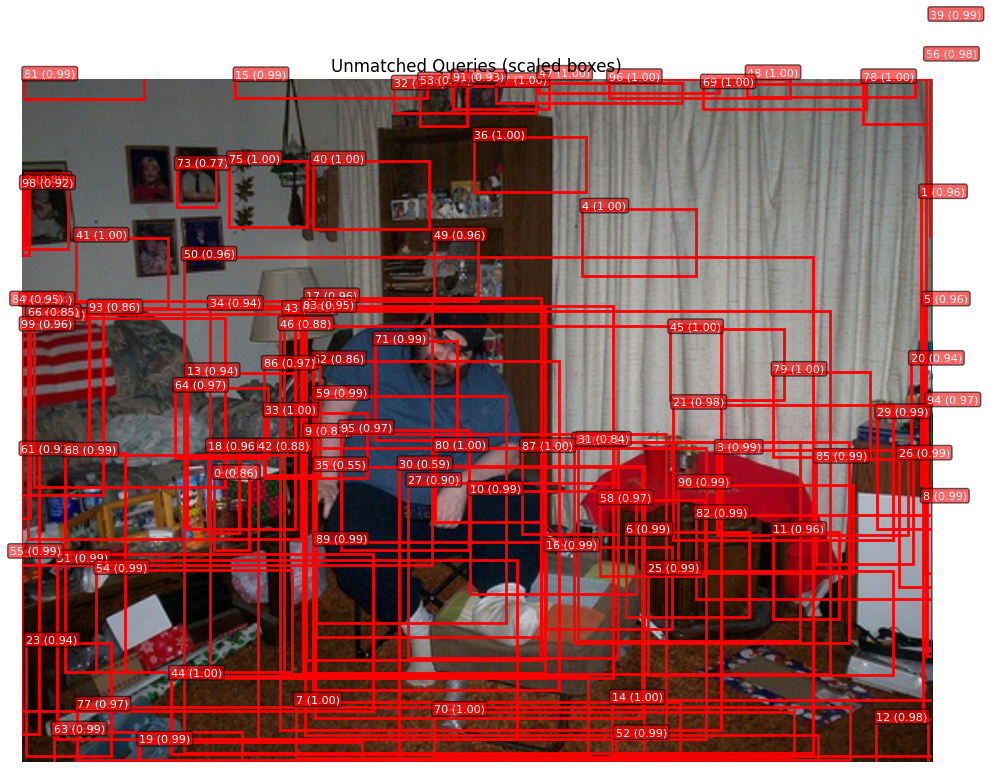

In [ ]:
visualize_unmatched_queries(model, matcher, image[0], target, device)

In [ ]:
matched_data = np.load("matched_embeddings.npz")
unmatched_data = np.load("unmatched_embedding.npz")

In [ ]:
for k in matched_data.keys():
    print(k)

embeddings
labels


In [ ]:
query_embeddings = matched_embedding

In [ ]:
mat

In [ ]:
# 차원 축소 (PCA 예시)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(query_embeddings)  # [num_queries, 2]

# 정규화된 바운딩 박스를 원본 이미지 크기로 변환
boxes = box_cxcywh_to_xyxy(outputs['pred_boxes'][0].cpu())
boxes[:, [0, 2]] *= image_pil.width
boxes[:, [1, 3]] *= image_pil.height

NameError: name 'outputs' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA

# 이미지 불러오기
image_pil = Image.open("/mnt/data/F4A60489-210B-426F-912C-0C6167869E82.png")

# 예시 임베딩 및 바운딩 박스 생성 (실제 데이터로 대체 가능)
query_embeddings = np.random.randn(100, 256)
boxes = np.random.rand(100, 4)
boxes[:, [0, 2]] *= image_pil.width
boxes[:, [1, 3]] *= image_pil.height

# PCA로 임베딩 2D 변환
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(query_embeddings)

# 박스 중심 좌표 계산
box_centers = (boxes[:, :2] + boxes[:, 2:]) / 2

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# (1) 임베딩 공간
ax1.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', s=30)
for i, (x, y) in enumerate(reduced_embeddings):
    ax1.text(x, y, str(i), fontsize=8, color='black')
ax1.set_title("2D Query Embeddings (PCA)")
ax1.grid(True)

# (2) 원본 이미지에 바운딩 박스
ax2.imshow(image_pil)
for i, box in enumerate(boxes):
    x0, y0, x1, y1 = box
    w, h = x1 - x0, y1 - y0
    rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='red', facecolor='none')
    ax2.add_patch(rect)
    ax2.text(x0, y0, str(i), fontsize=8, color='white',
             bbox=dict(facecolor='red', alpha=0.5, boxstyle='round,pad=0.2'))

ax2.set_title("Query Bounding Boxes")
ax2.axis("off")

# 포인트-박스 중심 연결
for i in range(len(query_embeddings)):
    pca_x, pca_y = reduced_embeddings[i]
    box_x, box_y = box_centers[i]
    con = ConnectionPatch(xyA=(pca_x, pca_y), coordsA=ax1.transData,
                          xyB=(box_x, box_y), coordsB=ax2.transData,
                          color="gray", linestyle="--", alpha=0.5)
    fig.add_artist(con)

plt.tight_layout()
plt.show()